In [1]:
import torch
from d2l import torch as d2l

In [2]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

这个标签 `#@save` 并不是Python语言的一部分，它通常出现在Jupyter Notebook或者Google Colab等类似环境中的代码单元格中。

这个标签的作用是为了方便地把代码块保存到一个文件中。当你在Jupyter Notebook中编写一个长的代码块时，可以使用这个标签指定要保存的代码块的名称，并在需要时使用特殊命令将其保存到.py文件中，以便于后续的使用和共享。

例如，在Jupyter Notebook中，你可以像这样使用 `#@save` 标签：

```python
# 这是一个示例代码块，使用了 @save 标签
# @save
def hello():
    print("Hello, world!")
```

然后，当你想把这个代码块保存到一个文件中时，可以使用特殊的 `%%writefile` 命令，并以该代码块中 `#@save` 标签后的名称作为文件名：

```python
%%writefile my_module.py
# 这是一个示例代码块，使用了 @save 标签
def hello():
    print("Hello, world!")
```

运行上面的代码后，该代码块就会被保存到名为 `my_module.py` 的文件中。

tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]])


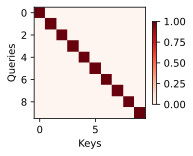

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
print(attention_weights)
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

随机生成一个10*10矩阵并使用softmax运算来确保每行都是有效的概率分布，然后可视化输出注意力权重。

tensor([[0.1013, 0.1249, 0.0812, 0.1552, 0.1024, 0.1545, 0.0610, 0.0707, 0.0791,
         0.0696],
        [0.0928, 0.0779, 0.0815, 0.1471, 0.0729, 0.1121, 0.1260, 0.0889, 0.0620,
         0.1389],
        [0.1060, 0.0979, 0.1231, 0.0750, 0.0777, 0.1324, 0.1007, 0.1219, 0.1044,
         0.0610],
        [0.1695, 0.0993, 0.0905, 0.0675, 0.1447, 0.0725, 0.0693, 0.1225, 0.0888,
         0.0755],
        [0.0881, 0.0893, 0.1497, 0.0776, 0.0819, 0.1276, 0.0830, 0.0863, 0.1294,
         0.0871],
        [0.0534, 0.1199, 0.0965, 0.1078, 0.0960, 0.1196, 0.0972, 0.0976, 0.1353,
         0.0768],
        [0.1176, 0.1297, 0.1035, 0.0599, 0.0862, 0.0762, 0.0921, 0.0954, 0.1332,
         0.1062],
        [0.1191, 0.1036, 0.1126, 0.1034, 0.1192, 0.1418, 0.0782, 0.0889, 0.0726,
         0.0606],
        [0.0877, 0.0712, 0.0986, 0.1035, 0.1312, 0.1354, 0.0881, 0.0981, 0.1206,
         0.0657],
        [0.1396, 0.1211, 0.0554, 0.1154, 0.1289, 0.0585, 0.1087, 0.0607, 0.1317,
         0.0799]])


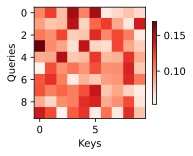

In [8]:
m = torch.rand(10, 10)
m = torch.softmax(m, dim=1, dtype=torch.float32)
print(m)
show_heatmaps(m.reshape((1, 1, 10, 10)), xlabel='Keys', ylabel='Queries')

# Nadaraya-Watson 核回归

框架下的注意力机制的主要成分：**查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚； 注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出**。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

n_train = 50  #训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)  #排序后的训练样本


def f(x):
    return 2 * torch.sin(x) + x ** 0.8


y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  #训练样本的输出（加了正态分布噪声）
x_test = torch.arange(0, 5, 0.1)  #测试样本
y_truth = f(x_test)  #测试样本的真实输出
n_test = len(x_test)  #测试样本数
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示）， 不带噪声项的真实数据生成函数（标记为“Truth”）， 以及学习得到的预测函数（标记为“Pred”）。

In [2]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

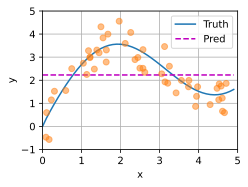

In [3]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

`torch.repeat_interleave`方法是PyTorch中的一个函数，用于将输入张量沿指定维度进行重复和插值。它的功能是重复输入张量的元素，并生成一个新的张量。

函数的语法如下：
```python
torch.repeat_interleave(input, repeats, dim=None)
```

参数说明：
- `input`：输入张量，需要进行重复的张量。
- `repeats`：重复的次数，可以是一个整数或一个张量。如果是整数，则所有维度上的重复次数都相同；如果是张量，则每个维度都可以指定不同的重复次数。
- `dim`（可选）：指定重复的维度。如果不提供此参数，则在整个张量上进行重复。

返回值：
- 返回一个新的张量，其中包含了重复和插值后的元素。

在给定的代码示例中，`torch.repeat_interleave(y_train.mean(), n_test)`的作用是将`y_train.mean()`的值重复插值成一个新的张量`y_hat`，重复的次数为`n_test`次。这样生成的`y_hat`张量将包含`y_train.mean()`的值重复了`n_test`次，用于在测试阶段进行预测或其他需要相同值的情况。

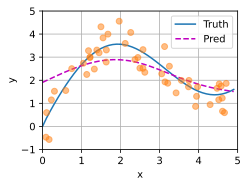

In [4]:
# 对x_test张量中的每一个元素进行n_train次数的插值，生成(n_test,n_train)形状的X_repeat张量
# 每一行都包含着相同的测试输入（例如：同样的查询），即每一行的测试输入都是x_test
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键，attention_weights的形状：(n_test,n_train)
# 每一行都包含着要在给定的每个查询的值(y_train)之间分配的注意力权重
# 计算X_repeat和x_train之间的相似程度，并根据该相似程度分配attention权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
# 将attention权重与y_train相乘
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

这里测试数据的输入相当于查询，而训练数据的输入相当于键。 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高。

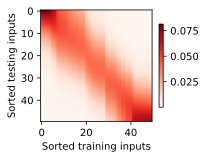

In [5]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [6]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape  #批量矩阵乘法

torch.Size([2, 1, 6])

In [14]:
weights = torch.ones((2, 10)) * 0.1
print(weights)
values = torch.arange(20.0).reshape((2, 10))
print(values)
print(weights.unsqueeze(1))  #(2,1,10)
print(values.unsqueeze(-1))  #(2,10,1)
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))  #(2,1,1)

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]])
tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]],

        [[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]])
tensor([[[ 0.],
         [ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.]],

        [[10.],
         [11.],
         [12.],
         [13.],
         [14.],
         [15.],
         [16.],
         [17.],
         [18.],
         [19.]]])


tensor([[[ 4.5000]],

        [[14.5000]]])

`weights.unsqueeze()`是PyTorch中的一个方法，用于在张量的指定维度上添加一个维度。它的作用是将原始张量的形状扩展为更高维度的形状。

具体来说，`unsqueeze()`方法的语法如下：
```python
unsqueeze(dim)
```
- `dim`：表示要添加维度的位置索引，即要在哪个位置上添加维度。可以是一个非负整数或一个元组。

`unsqueeze()`方法的返回值是一个新的张量，它是原始张量在指定维度上添加了一个维度后的结果。

在参数方面，可以填写以下数字：
- 要插入的维度的位置索引，例如0表示在第一个维度之前插入一个新的维度。
- 负数表示从最后一个维度开始计数，例如-1表示在最后一个维度之前插入一个新的维度。
- 如果需要在多个位置上添加维度，可以使用元组或列表来指定多个位置索引。

例如，假设有一个形状为`(3,)`的一维张量`x`，可以使用`unsqueeze()`方法将其形状扩展为`(1, 3)`的二维张量：
```python
x = torch.tensor([1, 2, 3])
x.unsqueeze(0)  # 结果是 tensor([[1, 2, 3]])
```
在这个例子中，`unsqueeze(0)`表示在第一个维度之前插入一个新的维度。

需要注意的是，`unsqueeze()`方法只是在指定位置上添加维度，并不改变原始张量中的元素值。它可以在进行广播、形状匹配或与其他要求相同形状的张量进行操作时很有用。

基于带参数的注意力汇聚，使用小批量矩阵乘法， 定义Nadaraya-Watson核回归的带参数版本为：

在注意力机制中，键（keys）、值（values）和查询（queries）是三个关键的概念。

1. 键（Keys）：键是用于表示非自主性提示的信息。它可以是感官输入的表示或其他相关信息。键提供了关于输入的重要特征或信息，用于计算注意力权重。

2. 值（Values）：值是对应于键的信息或表示。它可以是感官输入的表示或其他相关信息。值包含了被关注的元素或信息，用于计算注意力权重时的加权求和。

3. 查询（Queries）：查询是用于表示自主性提示的信息。它是我们希望根据键和值来关注的内容。查询包含了我们想要在值中查找或聚焦的信息，以指导注意力权重的计算。

在注意力机制中，通过计算查询与键之间的相似度或相关性，可以确定哪些值与查询更相关，从而给予这些值更高的注意力权重。查询、键和值之间的交互和计算方式可以根据具体的注意力机制的设计而有所不同，例如使用点积注意力、加性注意力等。

综上所述，查询用于指导注意力机制关注的内容，键提供了与输入相关的非自主性提示，而值包含了被关注的元素或信息。通过计算查询与键之间的相似度，可以为值分配不同的注意力权重，从而实现对不同值的加权聚焦。

In [24]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super(NWKernelRegression, self).__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键-值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w) ** 2 / 2, dim=1)
        # values的形状为(查询个数,“键-值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),  #(查询个数,1,“键-值“对个数)
                         values.unsqueeze(-1)).reshape(-1)  #(查询个数,“键-值”对个数,1)

这个类是一个基于非参数化核回归的注意力机制模型，被称为NWKernelRegression。下面是对这个类的解释：

1. `__init__(self, **kwargs)`：类的初始化方法。在这里，它继承了`nn.Module`类，并定义了一个可学习的参数`self.w`，它是一个形状为`(1,)`的张量，并且要求进行梯度计算。

2. `forward(self, queries, keys, values)`：类的前向传播方法。在这个方法中，传入三个参数：`queries`，`keys`，`values`，分别表示查询、键和值。

   a. `queries`：查询，包含了自主性提示的信息。它的形状为(查询个数, "键-值"对个数)。

   b. `keys`：键，包含了非自主性提示的信息。它的形状为(查询个数, "键-值"对个数)。

   c. `values`：值，包含了被关注的元素或信息。它的形状为(查询个数, "键-值"对个数)。

   在这个方法中，首先将查询`queries`在维度上重复和插值，使其形状变为(查询个数, "键-值"对个数)，以与键和值的形状相匹配。重复和插值使用了`repeat_interleave()`和`reshape()`方法。

   然后，通过计算相似度，使用以下步骤计算注意力权重：

      - `(queries - keys) * self.w`：计算查询与键之间的差值，并乘以参数`self.w`。这样可以根据查询和键之间的差异对注意力权重进行加权。

      - `-((queries - keys) * self.w) ** 2 / 2`：将上述结果的平方除以2，这是为了计算高斯核函数中的指数项，用于表示查询与键之间的相似度。

      - `nn.functional.softmax(..., dim=1)`：对上述计算得到的相似度应用 softmax 操作，以获得归一化的注意力权重。这样，注意力权重将表示查询对每个"键-值"对的关注程度。

   最后，使用注意力权重对值进行加权求和，并通过`torch.bmm()`方法进行批量矩阵乘法计算，得到最终的输出。注意，这里通过使用`unsqueeze()`方法为注意力权重和值添加了一个维度，以便进行矩阵乘法。最后，通过`reshape(-1)`将输出重新调整形状，以适应输出的要求。

   在前向传播过程中，注意力权重`self.attention_weights`被存储在模型中，以便在需要的时候进行访问和使用。

这个类实现了一个基于非参数化核回归的注意力机制模型，它通过计算查询与键之间的相似度来为值分配注意力权重，从而对值进行加权聚焦。在实际应用中，可以根据具体的任务和数据，调整模型中的参数和参数化方式，以适应不同的注意力需求。

In [25]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [20]:
print(X_tile)
print(keys)
print(Y_tile)
print(values)

tensor([[0.0866, 0.1034, 0.1676,  ..., 4.6126, 4.6630, 4.7064],
        [0.0866, 0.1034, 0.1676,  ..., 4.6126, 4.6630, 4.7064],
        [0.0866, 0.1034, 0.1676,  ..., 4.6126, 4.6630, 4.7064],
        ...,
        [0.0866, 0.1034, 0.1676,  ..., 4.6126, 4.6630, 4.7064],
        [0.0866, 0.1034, 0.1676,  ..., 4.6126, 4.6630, 4.7064],
        [0.0866, 0.1034, 0.1676,  ..., 4.6126, 4.6630, 4.7064]])
tensor([[0.1034, 0.1676, 0.2255,  ..., 4.6126, 4.6630, 4.7064],
        [0.0866, 0.1676, 0.2255,  ..., 4.6126, 4.6630, 4.7064],
        [0.0866, 0.1034, 0.2255,  ..., 4.6126, 4.6630, 4.7064],
        ...,
        [0.0866, 0.1034, 0.1676,  ..., 4.6052, 4.6630, 4.7064],
        [0.0866, 0.1034, 0.1676,  ..., 4.6052, 4.6126, 4.7064],
        [0.0866, 0.1034, 0.1676,  ..., 4.6052, 4.6126, 4.6630]])
tensor([[-0.4687,  0.5970, -0.5679,  ...,  0.6582,  0.5949,  1.8633],
        [-0.4687,  0.5970, -0.5679,  ...,  0.6582,  0.5949,  1.8633],
        [-0.4687,  0.5970, -0.5679,  ...,  0.6582,  0.5949,  1.8

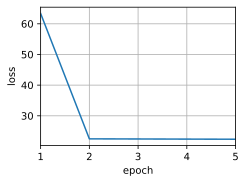

In [26]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')  #MSE损失函数
trainer = torch.optim.SGD(net.parameters(), lr=0.5)  #随机梯度下降
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

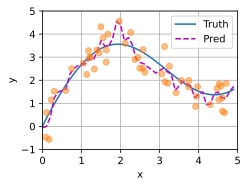

In [27]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

与非参数的注意力汇聚模型相比， 带参数的模型加入可学习的参数后， 曲线在注意力权重较大的区域变得更不平滑

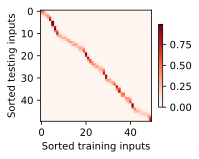

In [28]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# 注意力评分函数

In [38]:
import math

在某些情况下，并非所有的值都应该被纳入到注意力汇聚中.为了仅将有意义的词元作为值来获取注意力汇聚， 可以指定一个有效序列长度（即词元的个数）， 以便在计算softmax时过滤掉超出指定范围的位置。 下面的masked_softmax函数 实现了这样的掩蔽softmax操作（masked softmax operation）， 其中任何超出有效长度的位置都被掩蔽并置为0。

In [29]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X：3D张量，valid_lens：1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

为了演示此函数是如何工作的， 考虑由两个2*4矩阵表示的样本， 这两个样本的有效长度分别为2和3。 经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。

In [30]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3791, 0.6209, 0.0000, 0.0000],
         [0.4111, 0.5889, 0.0000, 0.0000]],

        [[0.2500, 0.3964, 0.3536, 0.0000],
         [0.4122, 0.3451, 0.2427, 0.0000]]])

同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。

In [31]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3909, 0.1876, 0.4215, 0.0000]],

        [[0.6673, 0.3327, 0.0000, 0.0000],
         [0.2248, 0.2786, 0.3137, 0.1828]]])

加性注意力：当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。

In [32]:
#@save
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)  # 全连接层，将
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features=queries.unsqueeze(2)+keys.unsqueeze(1)
        features=torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

这个类实现了加性注意力机制（Additive Attention），用于在给定查询（queries）、键（keys）和值（values）的情况下计算注意力权重并进行加权求和。

在初始化方法中，定义了三个线性层（`self.W_k`、`self.W_q`和`self.w_v`）用于将输入的查询、键和值映射到一个共享的隐藏表示空间。这些线性层分别将输入的特征大小（key_size、query_size）映射到一个指定大小（num_hiddens）的隐藏空间，并且不使用偏置项。另外，`dropout`参数用于指定在计算注意力权重时是否应用丢弃操作。

在前向传播方法中，通过将查询和键分别通过线性层`self.W_q`和`self.W_k`进行映射，将维度扩展，以便在特定维度上进行广播求和操作。具体来说，通过在维度上添加一个长度为1的维度，将queries的形状扩展为(batch_size，查询的个数，1，num_hidden)，将keys的形状扩展为(batch_size，1，“键-值”对的个数，num_hiddens)，然后使用广播方式进行求和，得到表示注意力特征的张量features。

接下来，将features通过激活函数tanh进行非线性变换。这样做的目的是引入非线性性质以增加模型的表达能力。

然后，将features通过线性层`self.w_v`映射到一个具有单个输出的空间，并移除最后一个维度。这样得到的scores表示了查询和键之间的相似度或关联程度。通过应用一个softmax函数（这里使用了一个自定义的带有有效长度限制的softmax函数`masked_softmax`），计算出注意力权重self.attention_weights。

最后，通过将注意力权重与值进行加权求和（使用torch.bmm函数进行批矩阵乘法），得到最终的加权值。最终的输出形状为(batch_size，查询的个数，值的维度)。

总之，这个类实现了加性注意力机制的前向传播过程，通过计算查询和键之间的相似度，并将相似度作为注意力权重应用于值，从而实现了对值的加权求和。

用一个小例子来演示上面的AdditiveAttention类，其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小），实际输出为（2，1，20）、（2，10，2）和（2，10，4）。注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。

In [34]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

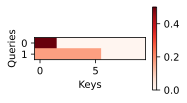

In [35]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

缩放点积注意力：使用点积可以得到计算效率更高的评分函数，但是点积操作要求查询和键具有相同的长度d。假设查询和键的所有元素都是独立的随机变量，并且都满足零均值和单位方差，那么两个向量的点积的均值为0，方差为d。为确保无论向量长度如何，点积的方差在不考虑向量长度的情况下仍然是1，我们再将点积除以根号d，得到缩放点积注意力（scaled dot-product attention）评分函数。

In [36]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

这个类实现了缩放点积注意力机制（Dot Product Attention），用于在给定查询（queries）、键（keys）和值（values）的情况下计算注意力权重并进行加权求和。

在初始化方法中，仅定义了一个dropout层，用于在计算注意力权重时应用丢弃操作。

在前向传播方法中，首先获取queries的维度d，这将用于进行缩放操作。然后，通过torch.bmm函数计算queries和keys之间的点积相似度。为了进行缩放，将点积相似度除以d的平方根。这个缩放操作有助于控制相似度的范围和数值稳定性。

接下来，通过应用一个softmax函数（这里使用了一个自定义的带有有效长度限制的softmax函数`masked_softmax`），计算出注意力权重self.attention_weights。

最后，通过将注意力权重与值进行加权求和（使用torch.bmm函数进行批矩阵乘法），得到最终的加权值。最终的输出形状为(batch_size，查询的个数，值的维度)。

总之，这个类实现了缩放点积注意力机制的前向传播过程，通过计算查询和键之间的点积相似度，并将相似度进行缩放和归一化作为注意力权重应用于值，从而实现了对值的加权求和。

为了演示上述的DotProductAttention类， 我们使用与先前加性注意力例子中相同的键、值和有效长度。 对于点积操作，我们令查询的特征维度与键的特征维度大小相同。

In [39]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])